In [10]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pickle
import pandas as pd
import scipy.stats as st


# my preferred settings
mpl.rc('lines',linewidth = 1.5)
mpl.rc('font',size = 14)
mpl.rc('axes',labelsize = 16, linewidth=1.25)
mpl.rc('xtick',labelsize = 16)
mpl.rc('ytick',labelsize = 16)
# enable math fonts
mpl.rc('mathtext', default = 'regular')
plt.rcParams['savefig.dpi'] = 400 

from sbin.complexity import gap_complexity, ecdf_confidence
import seaborn as sns 

from sbin.sbin import suppression_factor_simple
from sbin.sbin import suppression_factor 
from sbin.sbin import suppression_factor_snow, a_to_snow 





In [11]:
with open("filtered_data.pkl", "rb") as f:
     data = pickle.load(f)
              
close = data["close"]
good = data["good"]
db_filtered = data["db_filtered"]
kois_filtered = data["kois_filtered"]
kois_good = data["kois_good"]
cks_filtered = data["cks_filtered"]
cks_good = data["cks_good"]

with open("filtered_data_thebault.pkl", "rb") as f:
     tb_filtered = pickle.load(f)['db_filtered']
        

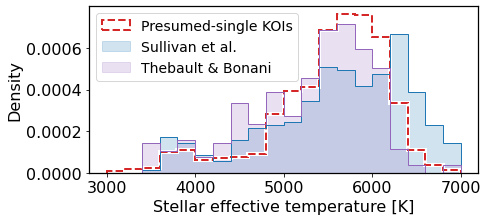

In [37]:
nbins = 20
histrange = (3000,7000)
fig, axes = plt.subplots(1, 1, figsize=(7,3.3), sharex=True, sharey=True)

plt.hist(kois_filtered['teff'], 
             range=histrange, bins=nbins, density=True, 
                histtype='step',lw=4, color='white')
plt.hist(kois_filtered['teff'], 
             range=histrange, bins=nbins, density=True, 
             histtype='step', lw=2, linestyle='--', color='C3',
            label='Presumed-single KOIs')

#plt.hist(cks_filtered['teff'], 
#             range=histrange, bins=nbins, density=True, 
#              histtype='step',lw=2, linestyle='--', color='C1',
#        label='CKS')

plt.hist(db_filtered['Teff1'], label='Sullivan et al.',
             range=histrange, bins=nbins, density=True, 
             histtype='stepfilled',  edgecolor='C0', facecolor='C0', alpha=0.2)
plt.hist(tb_filtered['teff'], label='Thebault & Bonani',
             range=histrange, bins=nbins, density=True, 
             histtype='stepfilled',  edgecolor='C4', facecolor='C4', alpha=0.2)

plt.hist(db_filtered['Teff1'], 
             range=histrange, bins=nbins, density=True, 
             histtype='step',  edgecolor='C0')
plt.hist(tb_filtered['teff'], 
             range=histrange, bins=nbins, density=True, 
             histtype='step',  edgecolor='C4')


plt.ylabel('Density')
plt.xlabel('Stellar effective temperature [K]')
plt.legend(loc='upper left')
plt.tight_layout()

plt.savefig('teff.png')

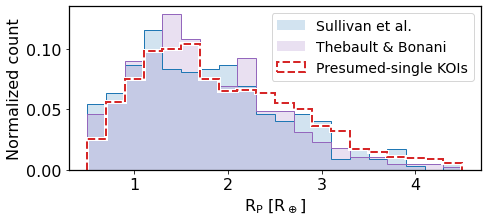

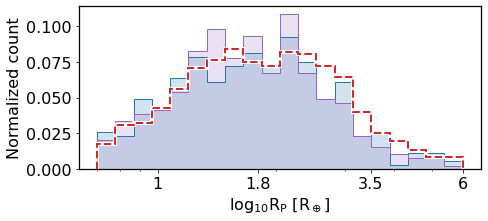

In [35]:

for option in ['linear','log']:

    nbins=20

    if option=='linear':
        histrange=[0.5,4.5]
        bin_edges = np.linspace(histrange[0], histrange[1], nbins + 1)
    else:
        histrange=[np.log10(0.7),np.log10(6)]
        bin_edges = np.logspace(histrange[0], histrange[1], nbins + 1)
        
    bin_width = np.diff(bin_edges)
    bin_center = bin_edges[:-1]+bin_width/2.
        
    fig, axes = plt.subplots(1, 1, figsize=(7,3.3), sharex=True, sharey=True)

    nplanets = len(db_filtered)
    ww = 1./np.full(nplanets, nplanets, dtype=float)
    y, _, _ = plt.hist(db_filtered['Rppri'], 
                  bins=bin_edges, weights=ww,
             histtype='step', edgecolor='C0', alpha=1)
    y, _, _ = plt.hist(db_filtered['Rppri'], 
                  bins=bin_edges, weights=ww,
             histtype='stepfilled', color='C0', alpha=0.2,
            label='Sullivan et al.')

    nplanets = len(tb_filtered)
    ww = 1./np.full(nplanets, nplanets, dtype=float)
    y, _, _ = plt.hist(tb_filtered['koi_prad'], 
                  bins=bin_edges, weights=ww,
             histtype='step', edgecolor='C4', alpha=1)
    y, _, _ = plt.hist(tb_filtered['koi_prad'], 
                  bins=bin_edges, weights=ww,
             histtype='stepfilled', color='C4', alpha=0.2,
            label='Thebault & Bonani')    
    
    # compared to the kois that are at least not definite binaries with good radii and per<100 days
    nplanets = len(kois_filtered)
    plt.hist(kois_filtered['koi_prad'], 
                 bins=bin_edges,  weights = 1./np.full(nplanets, nplanets, dtype=float),
                 histtype='step',lw=4, color='white')
    plt.hist(kois_filtered['koi_prad'], 
                 bins=bin_edges,  weights = 1./np.full(nplanets, nplanets, dtype=float),
                 histtype='step',lw=2, linestyle='--', color='C3',
            label='Presumed-single KOIs')

    plt.ylabel('Normalized count')
    
    if option=='linear':
        plt.legend()
        plt.xlabel('$R_P$ [$R_\oplus$]')        
    else:
        plt.xlabel('$log_{10} R_P$ [$R_\oplus$]')  
        plt.xscale('log')
        
        custom_log_ticks = [1, 1.8, 3.5, 6]
        plt.gca().set_xticks(custom_log_ticks)
        plt.gca().set_xticklabels([str(t) for t in custom_log_ticks])
        
    plt.tight_layout()
    plt.savefig('prad-'+option+'.png')

    plt.xlim()
    
    
    

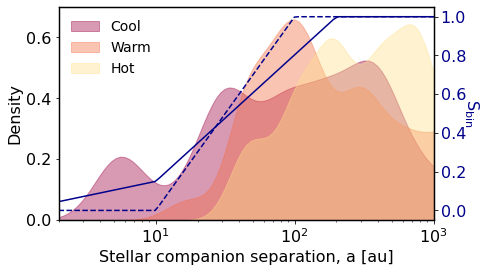

In [18]:
from scipy.stats import gaussian_kde

# ----------------------------------------------
# Set-up
# ----------------------------------------------

fig, ax1 = plt.subplots(figsize=(7, 4))

# defining the limits of the semi-major axis
a_values = np.logspace(-0.1,3, 100)
bins = np.logspace(np.log10(a_values.min()), np.log10(a_values.max()), 15)

# calculate suppression factors
S_values = suppression_factor(a_values)
S_values2 = suppression_factor_simple(a_values)


# ----------------------------------------------
# First axis -- histogram of planet radii
# ----------------------------------------------



# define the samples
cool = tb_filtered['semi-major'][tb_filtered['teff']<4500] # super-Earths
warm = tb_filtered['semi-major'][(tb_filtered['teff']>5500) & (tb_filtered['teff']<5800)] # in-betweens
hot = tb_filtered['semi-major'][tb_filtered['teff']>6000] # mini-Neptunes

def calc_pdf(sample):
    kde = gaussian_kde(np.log10(sample), bw_method=0.2)
    pdf = kde(np.log10(a_values))
    return pdf

ax1.fill_between(a_values, calc_pdf(cool), color='#9e0142', alpha=0.4,
                 label='Cool')
ax1.fill_between(a_values, calc_pdf(warm), color='#f46d43', alpha=0.4,
                 label='Warm')
ax1.fill_between(a_values, calc_pdf(hot), color='#fee08b', alpha=0.4,
                 label='Hot')


ax1.set_xscale('log') # Set the x-axis to logarithmic scale
ax1.set_ylabel('Density', color='k')
ax1.tick_params(axis='y', labelcolor='k')

ax1.set_xlabel('Stellar companion separation, a [au]')
plt.legend(edgecolor='None', facecolor='w', loc='upper left')
plt.ylim(0,0.7)


# ----------------------------------------------
# Second axis -- the suppression equation
# ----------------------------------------------

ax2 = ax1.twinx()

ax2.plot(a_values, S_values, color='darkblue', linestyle='-', label='Suppression Factor')
ax2.plot(a_values, S_values2, color='darkblue', linestyle='--', label='Suppression Factor')

#S_values = suppression_factor_snow(a_values, 5800.)
#ax2.plot(a_values, S_values, color='green', linestyle='--', label='Suppression Factor')

ax2.tick_params(axis='y', labelcolor='darkblue')

ax2.set_ylabel('$S_\mathrm{bin}$', rotation=270, color='darkblue', labelpad=15)


# ----------------------------------------------
# Adjust and save
# ----------------------------------------------

plt.xscale('log')
plt.xlim(2,1000.)
plt.tight_layout()
plt.savefig('overview-semimajor.png')

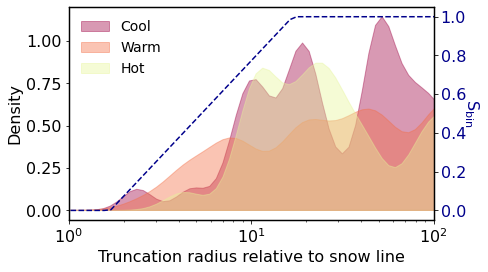

In [19]:
from scipy.stats import gaussian_kde

# ----------------------------------------------
# Set-up
# ----------------------------------------------

fig, ax1 = plt.subplots(figsize=(7, 4))

# defining the limits of the semi-major axis
a_values = np.logspace(-0.1,3.5, 100)
bins = np.logspace(np.log10(a_values.min()), np.log10(a_values.max()), 15)

# calculate suppression factors
S_values = suppression_factor_snow(a_values, 5800.)

# ----------------------------------------------
# First axis -- histogram of planet radii
# ----------------------------------------------

x = db_filtered['DiskAU']/db_filtered['SnowAU']
#x = db_filtered['SepAU']

# define the samples
cool = x[db_filtered['Teff1']<4500] # super-Earths
warm = x[(db_filtered['Teff1']>5000) & (db_filtered['Teff1']<5800)] # in-betweens
hot = x[db_filtered['Teff1']>6500] # mini-Neptunes

def calc_pdf(sample):
    kde = gaussian_kde(np.log10(sample), bw_method=0.2)
    pdf = kde(np.log10(a_values))
    return pdf

ax1.fill_between(a_values, calc_pdf(cool), color='#9e0142', alpha=0.4,
                 label='Cool')
ax1.fill_between(a_values, calc_pdf(warm), color='#f46d43', alpha=0.4,
                 label='Warm')
ax1.fill_between(a_values, calc_pdf(hot), color='#e6f598', alpha=0.4,
                 label='Hot')


ax1.set_xscale('log') # Set the x-axis to logarithmic scale
ax1.set_ylabel('Density', color='k')
ax1.tick_params(axis='y', labelcolor='k')

ax1.set_xlabel('Truncation radius relative to snow line')
plt.legend(edgecolor='None', facecolor='w', loc='upper left')


# ----------------------------------------------
# Second axis -- the suppression equation
# ----------------------------------------------

ax2 = ax1.twinx()

ax2.plot(a_to_snow(a_values), S_values, color='darkblue', linestyle='--', label='Suppression Factor')
#ax2.plot(a_values, S_values2, color='darkblue', linestyle='--', label='Suppression Factor')
ax2.tick_params(axis='y', labelcolor='darkblue')

ax2.set_ylabel('$S_\mathrm{bin}$', rotation=270, color='darkblue', labelpad=15)


# ----------------------------------------------
# Adjust and save
# ----------------------------------------------

plt.xscale('log')
plt.xlim(1,100)
plt.tight_layout()
plt.savefig('overview-snow.png')

## Snow line conversaion calculation

0.1599239353546918 -0.09934250188637843


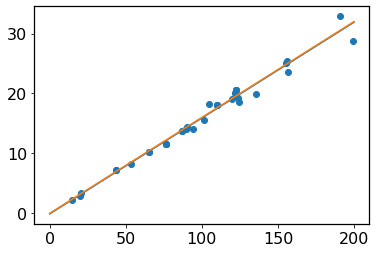

In [16]:
anchor = tb_filtered.loc[(tb_filtered['teff']>5600) & (tb_filtered['teff']<6000) & (tb_filtered['semi-major']<200.)]

x = anchor['semi-major']
y = anchor['DiskAU']/anchor['SnowAU']
plt.scatter(x,y)

x_fit = np.linspace(0,200, 100)
m_fit, b_fit = np.polyfit(x, y, 1)
print(m_fit, b_fit)

y_fit = b_fit + m_fit*x_fit
plt.plot(x_fit, y_fit)

a_to_snow = np.poly1d([0.16, 0.])
y_fit = a_to_snow(x_fit)
plt.plot(x_fit, y_fit)
